In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

from sklearn.datasets import make_blobs, make_circles, make_moons

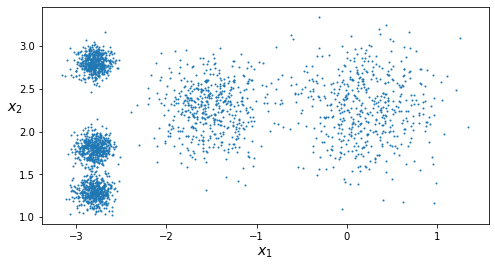

In [17]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.5,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=3000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

plt.figure(figsize=(8, 4))
plot_clusters(X)

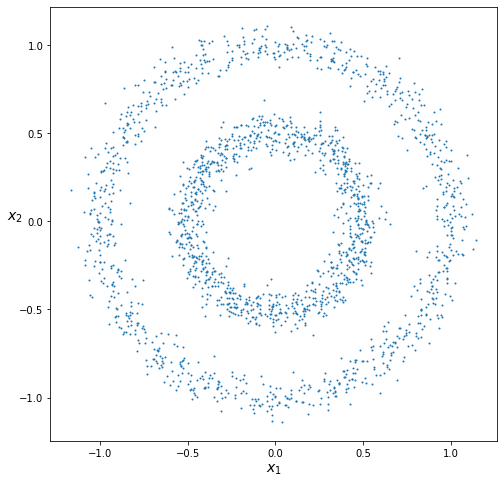

In [3]:
X, y = make_circles(2500, factor=0.5, noise=0.06)
plt.figure(figsize=(8, 8))
plot_clusters(X)

In [ ]:
X, y = make_moons(2500, noise=0.12)
plt.figure(figsize=(8, 4))
plot_clusters(X)

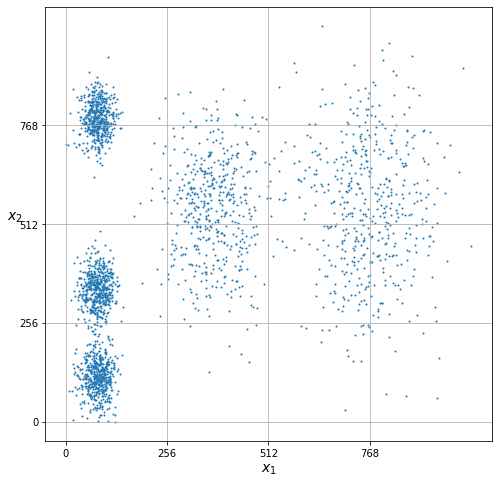

In [18]:
# масштабируем для начала данные:
from sklearn import preprocessing
SIZE = 1024
scaler = preprocessing.MinMaxScaler(feature_range=(0, SIZE))
X_scaled = scaler.fit_transform(X)

DIMENSION = X_scaled.shape[1]  # размерность пространства признаков

plt.figure(figsize=(8, 8))
plt.grid()
plt.xticks(np.arange(0,1024,256))
plt.yticks(np.arange(0,1024,256))
plot_clusters(X_scaled)

Задается параметр `DENOMINATOR` и заполняется осноная клетка `progenitor`. Работа на нулевом уровне.

In [30]:
from cluster import *

DENOMINATOR = 4                          # на сколько частей делится ребро клетки
ADJACENCY = 0.6
HOMOGENEITY = 6
DENSITY = 2

CONSTANTS = {
            "SIZE" : SIZE,
            "DIMENSION" : DIMENSION, 
            "DENOMINATOR" : DENOMINATOR,
            "ADJACENCY" : ADJACENCY,
            "HOMOGENEITY" : HOMOGENEITY,
            "DENSITY" : DENSITY,
            }

meanDens = len(X) / SIZE ** (DIMENSION - 1)             # средняя плотность точек

# создаем список с номерами всех экземпляров
sampleList = [i for i in range(len(y))]
# этот список будет также списком объектов клетки нулевой глубины

progenitor = HeadCell(CONSTANTS)               # создается объект основной клетки
progenitor.filling(sampleList, X_scaled, CONSTANTS)           # заполнение клетки
# на этом этапе только создается и заполняется клетка нулевой глубины

[]

Работа на первом уровне. Получаем списки однородных и неоднородных непустых клеток первого уровня в словарях `homoCells_1` и `otherCells_1`

depth = 1
Число однородных клеток:   1
Число неоднородных клеток: 9


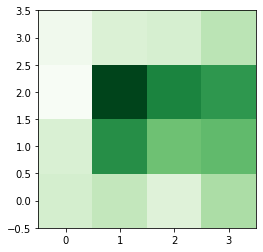

In [31]:
depth = 1                               # переходим на первый уровень
# создаются и заполняются клетки, разбивающие основную клетку progenitor:
# эти клетки [уровня 1] будут доступны через словарь otherCells_1
otherCells_1 = progenitor.disperse(X_scaled, CONSTANTS) # (клетки первого уровня)

# создаются и заполняются клетки, разбивающие клетки первого уровня:
for key in otherCells_1:
    otherCells_1[key].disperse(X_scaled, CONSTANTS)
    # print(key, otherCells_1[key].density)

grid = np.zeros((DENOMINATOR, DENOMINATOR))
for i in range(DENOMINATOR):
    for j in range(DENOMINATOR):
        grid[i, j] = otherCells_1[(i, j)].getHomogeneity(depth, CONSTANTS)
        # grid[i, j] = otherCells_1[(i, j)].density

# grid[1, 2] = 1

plt.imshow(grid.transpose(), origin='lower', cmap='Greens')

# по статистическим данным данным, получаемым по клеткам второго уровня,
# распределяются клетки первого уровня, словарь otherCells_1 обновляется:
otherCells_1, homoCells_1 = progenitor.separation(depth, CONSTANTS)
# otherCells_1 - прочие непустые клетки, homoCells_1 - однородные клетки

print(f'depth = 1\nЧисло однородных клеток:   {len(homoCells_1)}')
print(f'Число неоднородных клеток: {len(otherCells_1)}')

Работа на первом уровне. Образование кластеров из смежных клеток первого уровня. Разделение клеток кластеров на активные (внешние) и пассивные (внутренние). 

In [32]:
# класстеры будут содержаться в словаре clusters, и доступны по ключу номера кластера
clusters = dict()
clusterCounter = 0

remainCells = copy.copy(homoCells_1)    # этот словарь будут исчерпываться в цикле

# смежные однородные клетки первого уровня объединяются, образуя кластеры

while len(remainCells) > 0:
    cellList = []       # здесь соберутся клетки одного кластера
    cell = remainCells.popitem()[1]        # извлекаем и удаляем клетку

    tempCellList = []   # список соберет соседние клетки клетки cell
    for key in cell.getNeighbors():     # перебираем список позиций соседей
        # если эта соседняя клетка находится в словаре remainCells, то
        # перемещаем ее из remainCells в список соседних клеток tempCellList
        if key in remainCells.keys():   
            tempCellList.append(remainCells.pop(key))
    cellList.append(cell) # cell становится первой клеткой новго кластера
    expand(tempCellList, remainCells, cellList, otherCells_1, CONSTANTS)
    # в результате в списке cellList будут собраны всек клетки, которые
    # находятся с клеткой cell в одном кластере
    clusterCounter += 1
    clusters[clusterCounter] = Cluster(cellList, depth, CONSTANTS)

print(f'Число кластеров: {len(clusters)}')

# после того как кластеры образованы, нужно собрать их внешние (активные) клетки:
for nmbr in clusters:
    clusters[nmbr].collectOuterSubCells(depth, X_scaled, CONSTANTS)
    print(f'    active: {len(clusters[nmbr].activeCellDict[depth+1])}')

Число кластеров: 1
    active: 12


In [33]:
def showClusterCells(clusters, maxDepth, CONSTANTS, various=False):
    """Рисует рспределение класторов
    clusters: dict - клатсеры
    maxDepth: int - глубина самых мелких клеток (depth+2)
    """
    DENOMINATOR = CONSTANTS["DENOMINATOR"]
    def fillGrid(cell, grid, value):
        d = DENOMINATOR ** (maxDepth - cell.depth)
        gridPosition = cell.globalPosition[0] * d, cell.globalPosition[1] * d
        counter = 0
        for i in range(d):
            for j in range(d):
                counter += 1
                x = gridPosition[0]+i
                y = gridPosition[1]+j
                grid[x, y] = value
        return counter
    
    lenght = DENOMINATOR ** maxDepth
    grid = np.zeros((lenght, lenght))
    
    for depth in range(1, maxDepth):
        for clusterNumber in clusters:
            cluster = clusters[clusterNumber]
            value = clusterNumber if various else 1 
            if cluster.activeCellDict.get(depth, None):
                for pstn in cluster.activeCellDict.get(depth, None):
                    cell = cluster.activeCellDict[depth][pstn]
                    # print(f'active |{pstn}, depth: {cell.depth}')
                    fillGrid(cell, grid, value)

                for pstn in cluster.passiveCellDict.get(depth, None):
                    cell = cluster.passiveCellDict[depth][pstn]
                    # print(f'passive {pstn}, depth: {cell.depth}')
                    fillGrid(cell, grid, value)

    plt.xticks([])   # убираем
    plt.yticks([])   # деления
    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    plt.imshow(grid.transpose(), origin='lower', cmap='gist_earth', alpha=0.8)

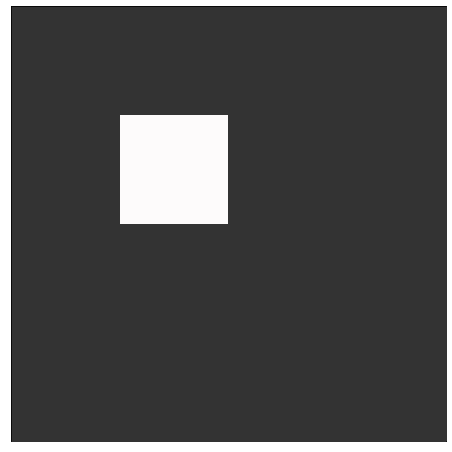

In [34]:
showClusterCells(clusters, depth+2, CONSTANTS, True)

Работа на втором уровне

otherCells_2 144
homoCells_2 48
clusters: {1: <cluster.Cluster object at 0x000001DF118F59D0>}


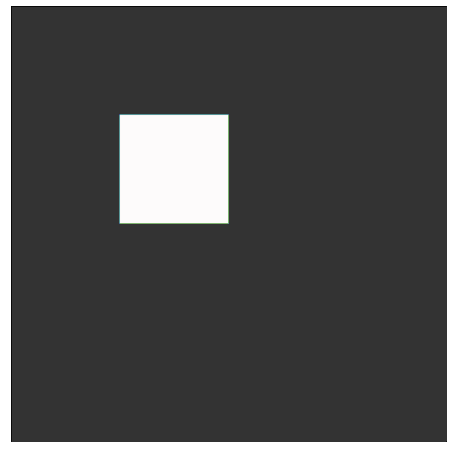

In [35]:
depth = 2       # переходим на второй уровень
# собираем в словарь otherCells_2 клетки второго уровня из неоднородных
# клеток первого уровня (по ключам, соответствующим глобальной позиции)
otherCells_2 = dict()
for key in otherCells_1:
    for k in otherCells_1[key].subCells:
        otherCells_2[otherCells_1[key].subCells[k].globalPosition] = otherCells_1[key].subCells[k]

# создаются и заполняются клетки, разбивающие клетки второго уровня:
for key in otherCells_2:
    otherCells_2[key].disperse(X_scaled, CONSTANTS)
# по статистическим данным данным, получаемым по клеткам третьего уровня,
# распределяются клетки второго уровня:
for key in otherCells_1:
    otherCells_1[key].separation(depth, CONSTANTS)

homoCells_2 = dict()    # будет содержать однородные клетки
# словарь otherCells_2 обновляется, создается словарь с однородными клетками:
for key in otherCells_1:
    for k in otherCells_1[key].subCells:
        otherCells_2[otherCells_1[key].subCells[k].globalPosition] = otherCells_1[key].subCells[k]
    for k in otherCells_1[key].homoCells:
        homoCells_2[otherCells_1[key].homoCells[k].globalPosition] = otherCells_1[key].homoCells[k]

print('otherCells_2', len(otherCells_2))
print('homoCells_2', len(homoCells_2))
print('clusters:', clusters)

showClusterCells(clusters, depth+2, CONSTANTS, True)

homoCells_2 40
otherCells_2 144


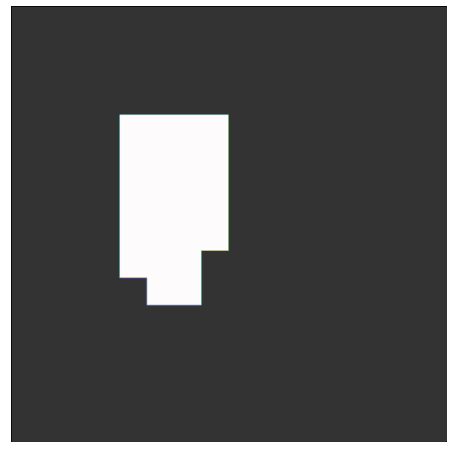

In [25]:
# расширяем кластеры на однородные клетки второго уровня:
while True:
    before = len(homoCells_2)
    for nmbr in clusters:
        clusters[nmbr].expand(homoCells_2, otherCells_2, depth, CONSTANTS)
    if before == len(homoCells_2):
        break

print('homoCells_2', len(homoCells_2))
print('otherCells_2', len(otherCells_2))

showClusterCells(clusters, depth+2, CONSTANTS, True)

Работа на втором уровне. Из оставшихся клеток второго уровня выбирается произвольная клетка, которая образует новый кластер, после чего этот кластер тут же начинает расширяться на соседние однородные клетки второго уровня. Затем снова выбирается произвольная клетка из оставшихся и все повторяется до исчерпания всех оставшихся клеток

    active: 98
    active: 109
    active: 34
    active: 73


{1: <cluster.Cluster at 0x1df11984100>,
 2: <cluster.Cluster at 0x1df106e70a0>,
 3: <cluster.Cluster at 0x1df106e70d0>,
 4: <cluster.Cluster at 0x1df106e71f0>}

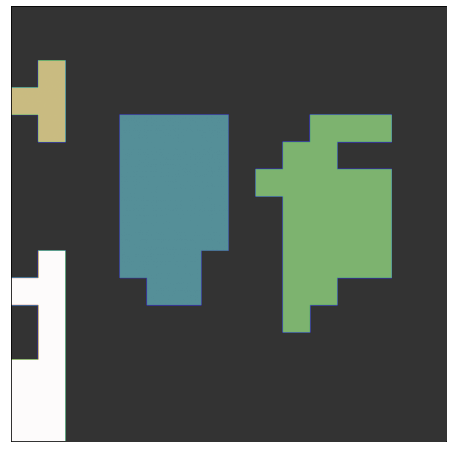

In [26]:
remainCells = copy.copy(homoCells_2)

# смежные однородные клетки второго уровня объединяются, образуя кластеры

while len(remainCells) > 0:
    cellList = []       # здесь соберутся клетки одного кластера
    cell = remainCells.popitem()[1]        # извлекаем и удаляем клетку

    tempCellList = []   # список соберет соседние клетки клетки cell
    for key in cell.getNeighbors():     # перебираем список позиций соседей
        # если эта соседняя клетка находится в словаре remainCells, то
        # перемещаем ее из remainCells в список соседних клеток tempCellList
        if key in remainCells.keys():   
            tempCellList.append(remainCells.pop(key))
    cellList.append(cell) # cell становится первой клеткой новго кластера
    expand(tempCellList, remainCells, cellList, otherCells_2, CONSTANTS)
    # в результате в списке cellList будут собраны всек клетки, которые
    # находятся с клеткой cell в одном кластере
    clusterCounter += 1
    clusters[clusterCounter] = Cluster(cellList, depth, CONSTANTS)

for cluster in clusters.values():
    cluster.collectOuterSubCells(depth, X_scaled, CONSTANTS)
    print(f'    active: {len(cluster.activeCellDict[depth+1])}')

showClusterCells(clusters, depth+2, CONSTANTS, True)
clusters

Работа на третьем уровне

otherCells_3 2304
homoCells_3 121
clusters: {1: <cluster.Cluster object at 0x000001DF11984100>, 2: <cluster.Cluster object at 0x000001DF106E70A0>, 3: <cluster.Cluster object at 0x000001DF106E70D0>, 4: <cluster.Cluster object at 0x000001DF106E71F0>}


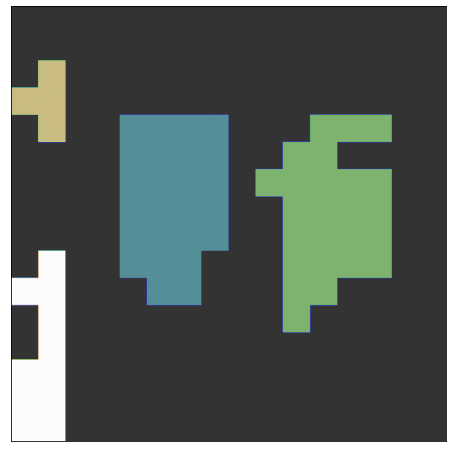

In [27]:
depth = 3       # переходим на третий уровень
# собираем в словарь otherCells_3 клетки третьего уровня из неоднородных
# клеток второго уровня (по ключам, соответствующим глобальной позиции)
otherCells_3 = dict()
for key in otherCells_2:
    for k in otherCells_2[key].subCells:
        otherCells_3[otherCells_2[key].subCells[k].globalPosition] = otherCells_2[key].subCells[k]

# создаются и заполняются клетки, разбивающие клетки третьего уровня:
for key in otherCells_3:
    otherCells_3[key].disperse(X_scaled, CONSTANTS)
# по статистическим данным данным, получаемым по клеткам третьего уровня,
# распределяются клетки второго уровня:
for cell in otherCells_2.values():
    cell.separation(depth, CONSTANTS)

homoCells_3 = dict()
# словарь otherCells_3 обновляется, создается словарь с однородными клетками:
for key in otherCells_2:
    for k in otherCells_2[key].subCells:
        otherCells_3[otherCells_2[key].subCells[k].globalPosition] = otherCells_2[key].subCells[k]
    for k in otherCells_2[key].homoCells:
        homoCells_3[otherCells_2[key].homoCells[k].globalPosition] = otherCells_2[key].homoCells[k]

print('otherCells_3', len(otherCells_3))
print('homoCells_3', len(homoCells_3))
print('clusters:', clusters)

showClusterCells(clusters, depth+2, CONSTANTS, True)

homoCells_2 2
otherCells_2 2304


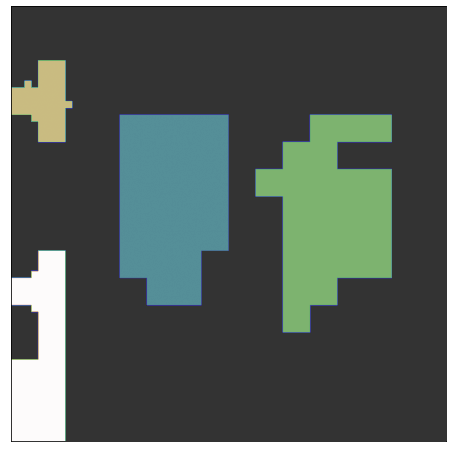

In [28]:
# расширяем кластеры на однородные клетки третьего уровня:
while True:
    before = len(homoCells_3)
    for nmbr in clusters:
        clusters[nmbr].expand(homoCells_3, otherCells_3, depth, CONSTANTS)
    if before == len(homoCells_3):
        break

print('homoCells_2', len(homoCells_3))
print('otherCells_2', len(otherCells_3))

showClusterCells(clusters, depth+2, CONSTANTS, True)

In [29]:
clusters

{1: <cluster.Cluster at 0x1df11984100>,
 2: <cluster.Cluster at 0x1df106e70a0>,
 3: <cluster.Cluster at 0x1df106e70d0>,
 4: <cluster.Cluster at 0x1df106e71f0>}